# Spectrum calculation

For now, this primarily presents how valence calculations can be calculated.

In [6]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
import veloxchem as vlx
import gator
import adcc
import multipsi as mtp
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection
from veloxchem.lreigensolver import LinearResponseEigenSolver


# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

## Absorption

(sec:adc-spectra)=
### Spectra from ADC eigenstates

In [7]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(struct,'6-31G')

# Perform SCF calculation
scf_gs = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates
adc_res = gator.run_adc(struct,basis,scf_gs,method='adc2x',singlets=6)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
         

SCF converged in 4 iterations.
Total Energy: -75.9838703758 au
Starting adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    12       0.20724  347ms  [0.39309489 0.47885444 0.48967157 0.57625436 0.62858585 0.76629423]
  2    24      0.007985  463ms  [0.29267016 0.3787924  0.38654776 0.47970941 0.55600566 0.68790077]
  3    36    0.00061329  517ms  [0.28987243 0.37555521 0.38250946 0.47481199 0.55294838 0.68421809]
  4    48    6.3694e-05  686ms  [0.28977127 0.37537428 0.38225998 0.47445428 0.55269124 0.68386045]
  5    60    1.0751e-05  798ms  [0.28976658 0.3753642  0.38224781 0.47442928 0.55266689 0.68380929]
=== Restart ===
  6    24    1.5639e-06  719ms  [0.2897665  0.37536398 0.38224737 0.47442845 0.55266552 0.68380092]
  7    36    2.9907e-07  669ms  [0.28976649 0.37536397 0.38224733 0.47442838 0.55266534 0.68379972]
=== Converged ===
    Number of matrix applies:    84
    Total solver time:             4s 282ms


The resuls can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| adc2x                                   singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     0.2897665      7.884948   0.0128    0.9391   0.06092  |
|  1      0.375364      10.21417   0.0000    0.9433   0.05668  |
|  2     0.3822473      10.40148   0.1114    0.9381   0.06186  |
|  3     0.4744284      12.90985   0.1033    0.9414   0.05865  |
|  4     0.5526653      15.03879   0.4241     0.957   0.04298  |
|  5     0.6837997      18.60714   0.2462    0.9493   0.05066  |
+--------------------------------------------------------------+



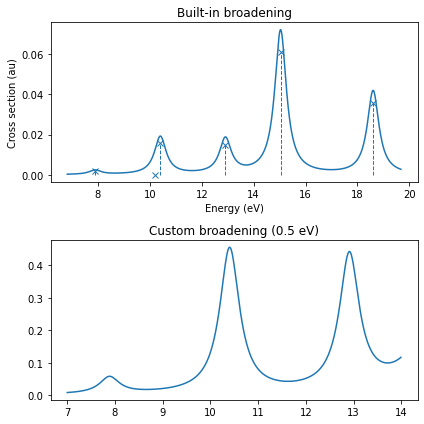

In [8]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    '''
    Lorentzian broadening function
    
    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    '''
    Gaussian broadening function
    
    Call: xi,yi = gaussian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)): 
        for k in range(len(y)): yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,6))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening')
adc_res.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening (0.5 eV)')
x,y  = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,7,14,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

The built-in functionalities can use several different energy-axis (note that broadening for `nm` is not enables):

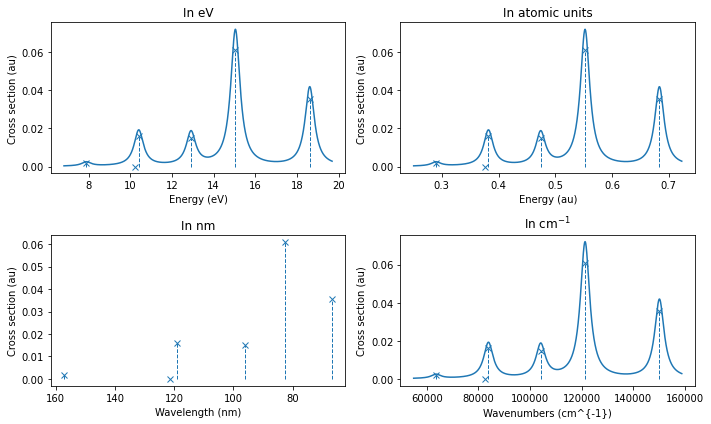

In [9]:
plt.figure(figsize=(10,6))
plt.subplot(221); plt.title('In eV')
adc_res.plot_spectrum(xaxis='eV')

plt.subplot(222); plt.title('In atomic units')
adc_res.plot_spectrum(xaxis='au')

plt.subplot(223); plt.title('In nm')
adc_res.plot_spectrum(xaxis='nm',broadening=None)

plt.subplot(224); plt.title(r'In cm$^{-1}$')
adc_res.plot_spectrum(xaxis='cm-1')
plt.tight_layout(); plt.show()

The built-in functionality uses a small default broadening and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region. A larger basis set will flatten out this region, but care should be taken for any analysis of that part of the spectrum.

### Spectra from CPP-ADC

```{note}
To be added.
```

### Spectra from TDDFT eigenstates

In [10]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# resolve four eigenstates
rpa_solver = LinearResponseEigenSolver(comm, ostream=silent_ostream)
rpa_solver.update_settings({'nstates':6},method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_drv.scf_tensors)

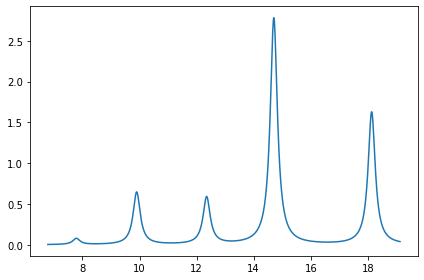

In [11]:
plt.figure(figsize=(6,4))
x = au2ev*rpa_results['eigenvalues']
y = rpa_results['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1.0,max(x)+1.0,0.01,0.3)
plt.plot(xi,yi); plt.tight_layout(); plt.show()

### Spectra from CPP-DFT

In [12]:
# Define spectrum region to be resolved
freqs = np.arange(7.0,23.0,0.1)/au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev},method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = - cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = - cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = - cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

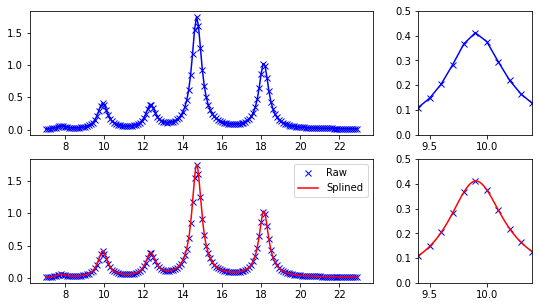

In [13]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(9,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev*freqs,sigma,'bx-')

# Raw results for a zoomed in region
plt.subplot(gs[1])
plt.plot(au2ev*freqs,sigma,'bx-')
plt.xlim((9.4,10.4)); plt.ylim((0,0.50))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev*freqs,sigma,'bx')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'r')
plt.legend(('Raw','Splined'))

# Zoomed in raw and splined spectra for the full region
plt.subplot(gs[3])
plt.plot(au2ev*freqs,sigma,'bx')
plt.plot(x,y(x),'r')
plt.xlim((9.4,10.4)); plt.ylim((0,0.50))
plt.show()

### Spectra from MCSCF

In some cases, it can be preferable to use a multiconfigurational wavefunction to compute excitation energies. One reason would be if the molecule is suspected to have strong correlation effects. Another reason is because the user is interested in analyzing a conical intersection, something that ADC and TD-DFT can fail to properly describe.

In principle, a MCSCF spectrum can be computed using response theory similarly to ADC and DFT. However, as configuration interaction (CI) can naturally provide not just the lowest but any state, it is possible to produce excited states by simply increasing the number of requested states or "roots" in the CI. However, in traditional MCSCF, the orbitals cannot be simultaneously optimized for each state, and instead we use a set of orbitals that is a compromise between all states, the state-averaged orbitals.

For water in its equilibrium distance, there is no strong correlation, and thus the only orbitals we need to include in the active space are those that can be excited in the UV-visible spectrum. Here, will use a CASSCF with an active space comprising the molecular orbitals formed by the oxygen 2p and hydrogen 1s, corresponding to the 2 $\sigma$ and $\sigma^*$ and one oxygen lone pair. We could in principle include the other lone pair, formed mostly by the 2s orbital of the oxygen, but its orbital energy is much lower and the orbital is thus not involved in the lowest UV-visible transitions.

The orbitals are conveniently located around the HOMO-LUMO gap, so it is sufficient to request a CAS(6,5) (6 electrons in 5 orbitals) to get the desired active space.

In [14]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")
# SCF calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)
# Active space settings
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.CAS(6,5) #3 O_2p and 2 H_1s
# CASSCF calculation
mcscf_drv = mtp.McscfDriver()
mcscf_drv.compute(molecule, basis, space, 8) #8 excited states
# Transition properties
SI = mtp.InterState()
DipOsc = SI.diposc(molecule, basis, mcscf_drv.CIVecs)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.506623781     0.0e+00      5.5e-01          1   0:00:00
        2     -75.540807011    -3.4e-02      1.4e-01          1   0:00:00
        3     -75.543792372    -3.0e-03      4.2e-02          1   0:00:00
        4

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.47892         1.141113e-02    2.824519e-02
     1       4       10.37993         1.091572e-01    1.313786e-01
     1       5       12.51645         1.551735e-01    1.520667e-01
     1       6       14.59414         6.288546e-01    3.493972e-01
     1       8       20.25690         2.854204e-01    1.779223e-01


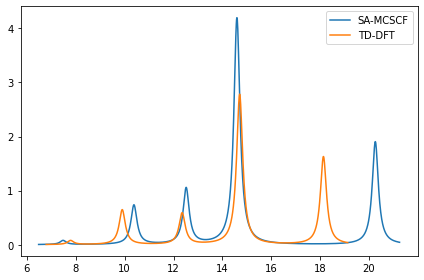

In [15]:
plt.figure(figsize=(6,4))
x = au2ev*DipOsc['energies']
y = DipOsc['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1.0,max(x)+1.0,0.01,0.3)
plt.plot(xi,yi, label='SA-MCSCF'); #plt.tight_layout(); plt.show()

#Comparing with TD-DFT
x = au2ev*rpa_results['eigenvalues']
y = rpa_results['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1.0,max(x)+1.0,0.01,0.3)
plt.plot(xi,yi, label='TD-DFT'); plt.tight_layout(); plt.legend(); plt.show()

## Emission

```{note}
To be added.
- Coumarin example
```


## Vibrations

```{note}
To be added.
```